In [1]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# May take awhile locally
spark = SparkSession.builder.appName("aggregate").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [2]:
cardio = spark.read.csv('C:/Users/Admin/DoAn/Datasets/CardioGoodFitness.csv',inferSchema=True,header=True)

In [16]:
cardio.printSchema()

root
 |-- Product: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Usage: integer (nullable = true)
 |-- Fitness: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Miles: integer (nullable = true)



In [4]:
cardio.limit(5).toPandas()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


In [5]:
# Counting null values in each column
cardio.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cardio.columns]).toPandas()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,0,0,0,0,0,0,0,0,0


In [6]:
# Count duplicates in all columns
duplicates = cardio.groupBy(cardio.columns).count().filter("count > 1")

# Show the duplicates
duplicates.toPandas()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles,count


In [7]:
# format the columns with two decimal places
cardio_desc = cardio.describe()
for col_name in ['Age', 'Education', 'Usage', 'Fitness', 'Income', 'Miles']:
    cardio_desc = cardio_desc.withColumn(col_name, format_number(col(col_name).cast("double"), 2))

# hide decimals if all zeroes
cardio_desc = cardio_desc.select(
    *[when(col(c).rlike('\.00$'), regexp_replace(col(c), '\.00', '')).otherwise(col(c)).alias(c) 
      for c in cardio_desc.columns]
)

cardio_desc.toPandas()

,summary,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,count,180,180,180,180,180,180,180,180,180
1,mean,None,28.79,None,15.57,None,3.46,3.31,"53,719.58",103.19
2,stddev,None,6.94,None,1.62,None,1.08,0.96,"16,506.68",51.86
3,min,TM195,18,Female,12,Partnered,2,1,"29,562",21
4,max,TM798,50,Male,21,Single,7,5,"104,581",360


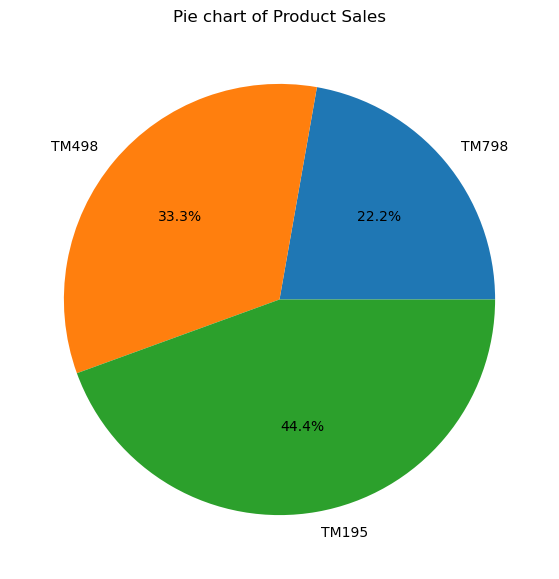

In [8]:
# group data by Product and count the number of rows
grouped = cardio.groupBy("Product").agg(count("*").alias("count"))

# convert to Pandas dataframe for visualization
df = grouped.toPandas()

# create a pie chart
fig, ax = plt.subplots(figsize=(14, 7))
ax.pie(df['count'], labels=df['Product'], autopct='%1.1f%%')
ax.set_title('Pie chart of Product Sales')

# display the chart
plt.show()

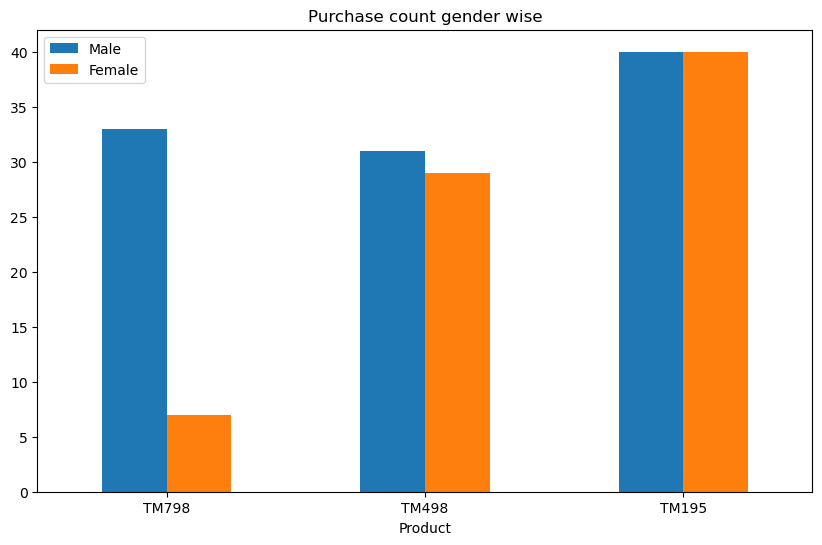

In [9]:
# group by Product and Gender and count the number of rows
grouped = cardio.groupBy("Product").pivot("Gender", ["Male", "Female"]).agg(count("*").alias("count"))

# convert to Pandas dataframe and plot

df = grouped.toPandas()
df.plot(kind="bar", x="Product", y=["Male", "Female"], figsize=(10, 6))
plt.title("Purchase count gender wise")

# set custom y-tick marks
plt.yticks(range(0, 41, 5))

# Rotate x-axis tick labels
plt.xticks(rotation=0)

plt.show()

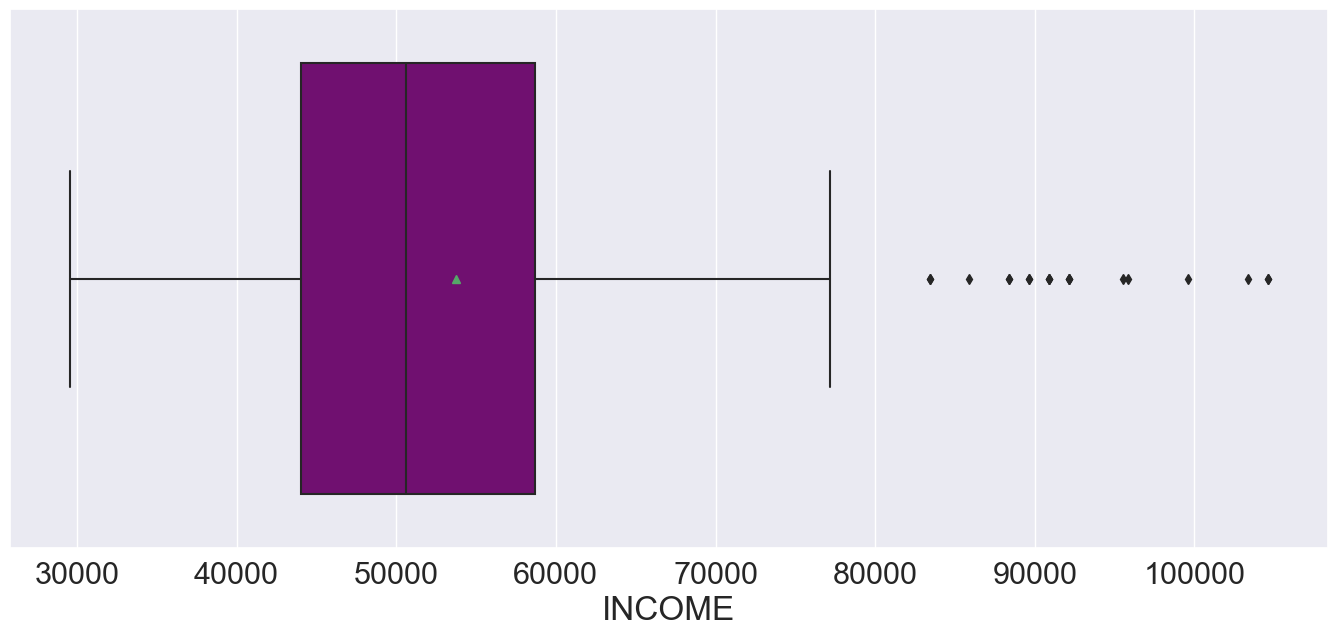

In [52]:
def dist_box_violin(data, col_name):
    Name = col_name.upper()
    fig, ax = plt.subplots(1, figsize=(17, 7))
    sns.boxplot(x=data.select(Name).toPandas()[Name], showmeans=True, orient='h', color="purple")

dist_box_violin(cardio, "Income")

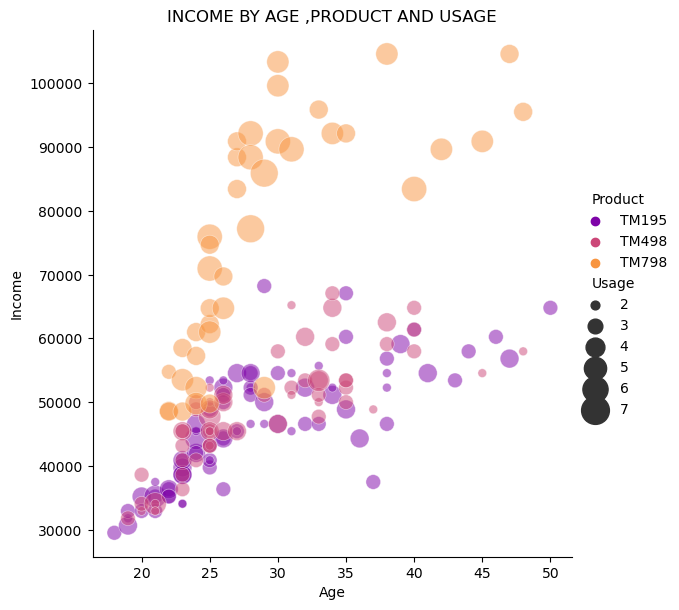

In [38]:
# Define the columns to use in the plot
cols = ['Age', 'Income', 'Product', 'Usage']

# Create a DataFrame containing only the selected columns
df = cardio.select(cols)

# Convert the DataFrame to a Pandas DataFrame
df_pd = df.toPandas()

# Create the plot using seaborn
sns.relplot(x="Age", y="Income", hue="Product", size="Usage",
            sizes=(40, 400), alpha=.5, palette="plasma",
            height=6, data=df_pd).set(title='INCOME BY AGE ,PRODUCT AND USAGE')

# Show the plot
plt.show()

In [22]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Define the columns you want to compute correlation for
cols = ['Age', 'Education', 'Usage', 'Fitness', 'Income', 'Miles']

# Assemble the columns into a single vector column
assembler = VectorAssembler(inputCols=cols, outputCol='features')
vector_df = assembler.transform(cardio).select('features')

# Compute the correlation matrix
corr_matrix = Correlation.corr(vector_df, 'features', method='pearson')

# Extract the correlation values from the matrix
corr_array = corr_matrix.collect()[0]['pearson({})'.format('features')].toArray()

# Convert the correlation matrix into a pandas dataframe
corr_df = pd.DataFrame(corr_array, columns=cols, index=cols)

# Display the correlation table
print(corr_df)

                Age  Education     Usage   Fitness    Income     Miles
Age        1.000000   0.280496  0.015064  0.061105  0.513414  0.036618
Education  0.280496   1.000000  0.395155  0.410581  0.625827  0.307284
Usage      0.015064   0.395155  1.000000  0.668606  0.519537  0.759130
Fitness    0.061105   0.410581  0.668606  1.000000  0.535005  0.785702
Income     0.513414   0.625827  0.519537  0.535005  1.000000  0.543473
Miles      0.036618   0.307284  0.759130  0.785702  0.543473  1.000000


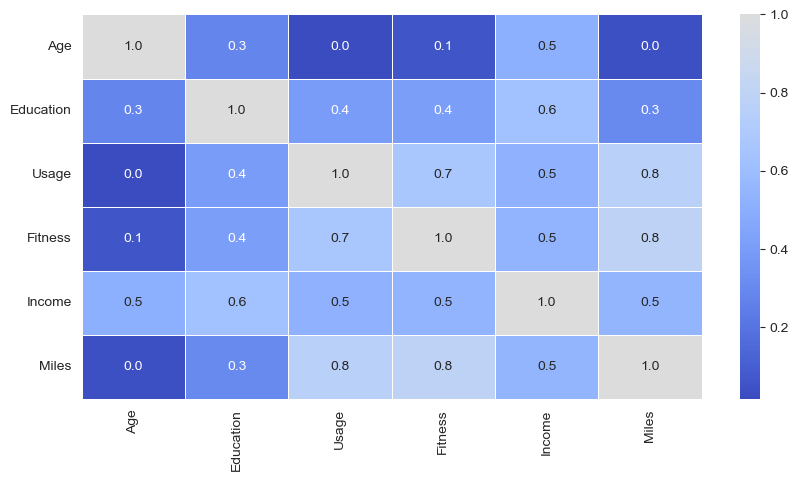

In [47]:
# select numerical columns
num_cols = ['Age', 'Education', 'Usage', 'Fitness', 'Income', 'Miles']

# select categorical columns
cat_cols = ['Gender', 'MaritalStatus', 'Product']

# vectorize the relevant columns
vector_assembler = VectorAssembler(inputCols=num_cols, outputCol='features')
vectorized_df = vector_assembler.transform(cardio).select('features')

# compute correlation matrix
corr_mat = Correlation.corr(vectorized_df, 'features')

# convert correlation matrix to a pandas dataframe
corr_df = pd.DataFrame(corr_mat.collect()[0]["pearson(features)"].toArray(),
                       columns=num_cols,
                       index=num_cols)

# plot heatmap using seaborn
plt.figure(figsize=(10,5))
sns.heatmap(corr_df, annot=True, linewidths=.5, fmt= '.1f', center = 1, cmap="coolwarm")

# rotate x-axis labels
plt.xticks(rotation=90)

# rotate y-axis labels
plt.yticks(rotation=0)

plt.show()

In [3]:
# Define the features and target columns
feature_cols = ['Usage', 'Fitness']
target_col = 'Miles'

# Combine the features into a single column called "features"
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
cardio = assembler.transform(cardio)

# Split the data into training and testing sets
train_data, test_data = cardio.randomSplit([0.7, 0.3], seed=0)

In [4]:
# Create a LinearRegression estimator object
lr = LinearRegression(featuresCol='features', labelCol='Miles')

# Fit the model using training data
lr_model = lr.fit(train_data)

# Make predictions on test data
lr_predictions = lr_model.transform(test_data)

# Evaluate the model using R^2 metric
evaluator = RegressionEvaluator(labelCol='Miles', predictionCol='prediction', metricName='r2')
r2 = evaluator.evaluate(lr_predictions)
print("OUTPUT: ", r2)

OUTPUT:  0.7992094340052229


In [5]:
lr = LogisticRegression(featuresCol='features', labelCol='Miles')

# fit the model to the training data
lr_model = lr.fit(train_data)

# make predictions on the testing data
predictions = lr_model.transform(test_data)

# select the predicted values
y_pred = predictions.select(col('prediction')).collect()
evaluator = MulticlassClassificationEvaluator(labelCol='Miles', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

print('The accuracy is', accuracy)

The accuracy is 0.1276595744680851
